In [1]:
# Standard Library Imports
import re
from collections import Counter

# Data Handling Libraries
import numpy as np
import pandas as pd

# Natural Language Processing (NLP) Libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Machine Learning Utilities and Models
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

# Deep Learning Libraries (TensorFlow/Keras)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Ensemble and Boosting Methods
from xgboost import XGBClassifier

# Sparse Matrix Package for Numeric Data
from scipy.sparse import csr_matrix

# Serialization/Deserialization Library
import pickle

# NLTK Resource Downloads
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/virgiliaantonucci/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/virgiliaantonucci/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

I am taking on the role of an employee at Twitter. We keep note of the reaction to trending topics. The following code determines whether we at Twitter should be running sentiment analysis on the hashtags included in tweets, or if we should ignore them entirely.

### EDA

In [2]:
# Load the datasets
test_df = pd.read_csv('/Users/virgiliaantonucci/Documents/Flatiron/phase_5/data/emotion-labels-test.csv')
train_df = pd.read_csv('/Users/virgiliaantonucci/Documents/Flatiron/phase_5/data/emotion-labels-train.csv')
val_df = pd.read_csv('/Users/virgiliaantonucci/Documents/Flatiron/phase_5/data/emotion-labels-val.csv')

# Check the first few rows of each dataset to understand their structure
test_head = test_df.head()
train_head = train_df.head()
val_head = val_df.head()

(test_head, train_head, val_head)

(                                                text label
 0  You must be knowing #blithe means (adj.)  Happ...   joy
 1  Old saying 'A #smile shared is one gained for ...   joy
 2  Bridget Jones' Baby was bloody hilarious 😅 #Br...   joy
 3  @Elaminova sparkling water makes your life spa...   joy
 4  I'm tired of everybody telling me to chill out...   joy,
                                                 text label
 0  Just got back from seeing @GaryDelaney in Burs...   joy
 1  Oh dear an evening of absolute hilarity I don'...   joy
 2  Been waiting all week for this game ❤️❤️❤️ #ch...   joy
 3  @gardiner_love : Thank you so much, Gloria! Yo...   joy
 4  I feel so blessed to work with the family that...   joy,
                                                 text label
 0  @theclobra lol I thought maybe, couldn't decid...   joy
 1  Nawaz Sharif is getting more funnier than @kap...   joy
 2  Nawaz Sharif is getting more funnier than @kap...   joy
 3  @tomderivan73 😁...I'll just people

In [3]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Initialize stop words and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text, remove_hashtags=False):
    # Convert to lowercase
    text = text.lower()
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove hashtags (if required)
    if remove_hashtags:
        text = re.sub(r'#\w+', '', text)
    # Tokenize
    tokenized_text = word_tokenize(text)
    # Remove stop words and punctuations
    tokenized_text = [word for word in tokenized_text if word.isalpha() and word not in stop_words]
    # Stemming
    stemmed_text = [stemmer.stem(word) for word in tokenized_text]
    # Join back into a string
    text = ' '.join(stemmed_text)
    return text

# Apply cleaning function to the train set for both versions: with and without hashtags
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
train_df['cleaned_text_no_hashtags'] = train_df['text'].apply(lambda x: clean_text(x, remove_hashtags=True))

train_df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/virgiliaantonucci/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/virgiliaantonucci/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


text label  \
0  Just got back from seeing @GaryDelaney in Burs...   joy   
1  Oh dear an evening of absolute hilarity I don'...   joy   
2  Been waiting all week for this game ❤️❤️❤️ #ch...   joy   
3  @gardiner_love : Thank you so much, Gloria! Yo...   joy   
4  I feel so blessed to work with the family that...   joy   

                                        cleaned_text  \
0  got back see burslem amaz face still hurt laug...   
1  oh dear even absolut hilar think laugh much lo...   
2                        wait week game cheer friday   
3  thank much gloria sweet thought made day joy love   
4  feel bless work famili nanni noth love amp app...   

                            cleaned_text_no_hashtags  
0  got back see burslem amaz face still hurt laug...  
1  oh dear even absolut hilar think laugh much lo...  
2                                     wait week game  
3  thank much gloria sweet thought made day joy love  
4  feel bless work famili nanni noth love amp app...

In [4]:
# Apply the cleaning function to the validation and test sets
val_df['cleaned_text'] = val_df['text'].apply(clean_text)
val_df['cleaned_text_no_hashtags'] = val_df['text'].apply(lambda x: clean_text(x, remove_hashtags=True))

test_df['cleaned_text'] = test_df['text'].apply(clean_text)
test_df['cleaned_text_no_hashtags'] = test_df['text'].apply(lambda x: clean_text(x, remove_hashtags=True))

# Display the heads of all dataframes to ensure cleaning was applied correctly
(train_df.head(), val_df.head(), test_df.head())

(                                                text label  \
 0  Just got back from seeing @GaryDelaney in Burs...   joy   
 1  Oh dear an evening of absolute hilarity I don'...   joy   
 2  Been waiting all week for this game ❤️❤️❤️ #ch...   joy   
 3  @gardiner_love : Thank you so much, Gloria! Yo...   joy   
 4  I feel so blessed to work with the family that...   joy   
 
                                         cleaned_text  \
 0  got back see burslem amaz face still hurt laug...   
 1  oh dear even absolut hilar think laugh much lo...   
 2                        wait week game cheer friday   
 3  thank much gloria sweet thought made day joy love   
 4  feel bless work famili nanni noth love amp app...   
 
                             cleaned_text_no_hashtags  
 0  got back see burslem amaz face still hurt laug...  
 1  oh dear even absolut hilar think laugh much lo...  
 2                                     wait week game  
 3  thank much gloria sweet thought made day joy lov

In [5]:
# Initialize CountVectorizer with the specified thresholds
vectorizer_cleaned = CountVectorizer(max_df=0.5, min_df=2)

# Vectorize the 'cleaned_text' column of the train, validation, and test sets
X_train_cleaned = vectorizer_cleaned.fit_transform(train_df['cleaned_text'])
X_val_cleaned = vectorizer_cleaned.transform(val_df['cleaned_text'])
X_test_cleaned = vectorizer_cleaned.transform(test_df['cleaned_text'])

# Getting feature names (words) from the vectorizer
feature_names_cleaned = vectorizer_cleaned.get_feature_names_out()

# Display some of the feature names to ensure vectorization was successful
feature_names_cleaned[:10]

array(['aaron', 'aateam', 'ab', 'aberdeen', 'abil', 'abl', 'abort',
       'absolut', 'absurd', 'abt'], dtype=object)

In [6]:
# Initialize CountVectorizer with the specified thresholds
vectorizer_no_hashtags = CountVectorizer(max_df=0.5, min_df=2)

# Vectorize the 'cleaned_text_no_hashtags' column of the train, validation, and test sets
X_train_no_hashtags = vectorizer_no_hashtags.fit_transform(train_df['cleaned_text_no_hashtags'])
X_val_no_hashtags = vectorizer_no_hashtags.transform(val_df['cleaned_text_no_hashtags'])
X_test_no_hashtags = vectorizer_no_hashtags.transform(test_df['cleaned_text_no_hashtags'])

# Getting feature names (words) from the vectorizer
feature_names_no_hashtags = vectorizer_no_hashtags.get_feature_names_out()

# Display some of the feature names to ensure vectorization was successful
feature_names_no_hashtags[:10]

array(['aaron', 'ab', 'aberdeen', 'abil', 'abl', 'absolut', 'absurd',
       'abt', 'abus', 'abysm'], dtype=object)

### Visualizations

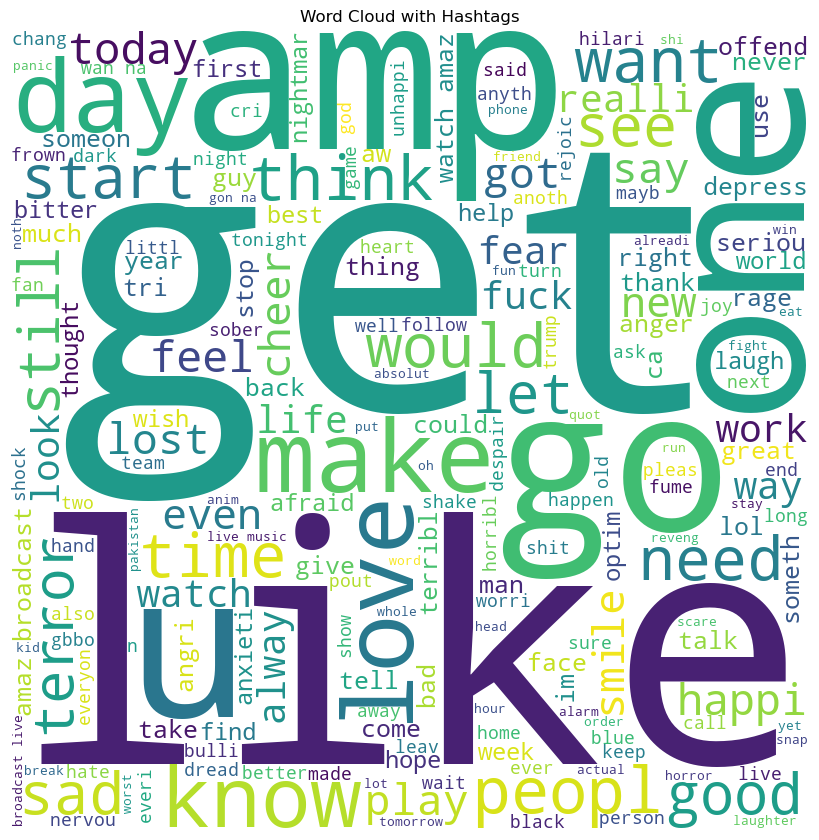

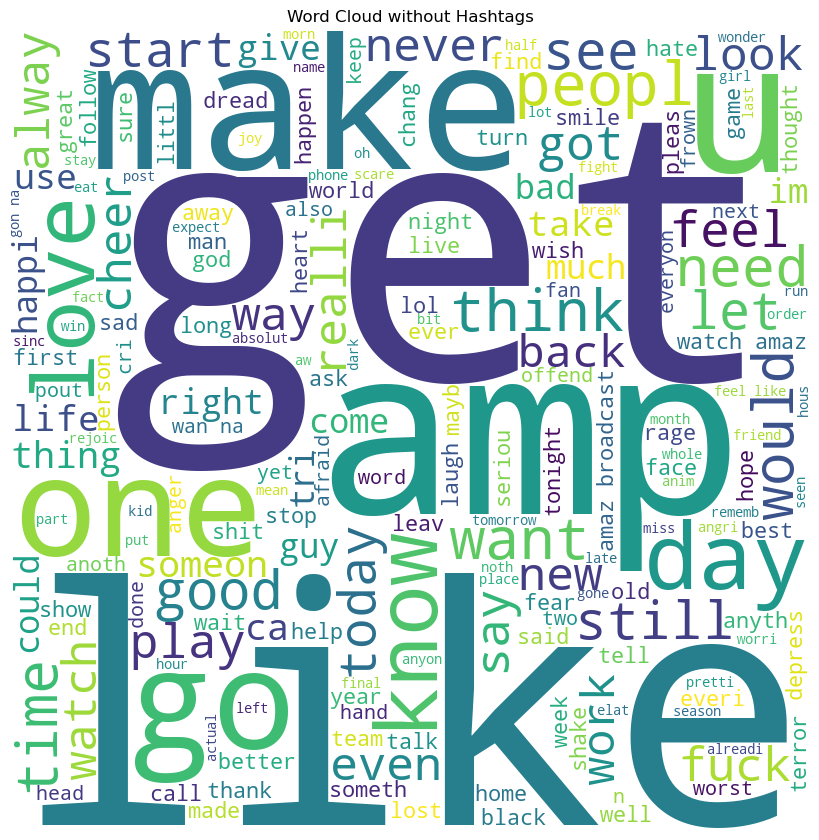

In [7]:
# Generate word clouds
# For cleaned text with hashtags
wordcloud_with_hashtags = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(' '.join(train_df['cleaned_text']))

# For cleaned text without hashtags
wordcloud_no_hashtags = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(' '.join(train_df['cleaned_text_no_hashtags']))

# Plot the word cloud for cleaned text with hashtags
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_with_hashtags) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Word Cloud with Hashtags")
plt.show()

# Plot the word cloud for cleaned text without hashtags
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_no_hashtags) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Word Cloud without Hashtags")
plt.show()

In [8]:
# Find the most common words for the 'cleaned_text' column which includes hashtags
sum_words_cleaned = X_train_cleaned.sum(axis=0)
words_freq_cleaned = [(word, sum_words_cleaned[0, idx]) for word, idx in vectorizer_cleaned.vocabulary_.items()]
words_freq_cleaned = sorted(words_freq_cleaned, key = lambda x: x[1], reverse=True)

# Get the top 10 most common words
common_words_with_hashtags = words_freq_cleaned[:10]

# Find the most common words for the 'cleaned_text_no_hashtags' column which excludes hashtags
sum_words_no_hashtags = X_train_no_hashtags.sum(axis=0)
words_freq_no_hashtags = [(word, sum_words_no_hashtags[0, idx]) for word, idx in vectorizer_no_hashtags.vocabulary_.items()]
words_freq_no_hashtags = sorted(words_freq_no_hashtags, key = lambda x: x[1], reverse=True)

# Get the top 10 most common words
common_words_without_hashtags = words_freq_no_hashtags[:10]

# Display the most common words with their counts for both versions
print("Most common words with hashtags:")
for word, freq in common_words_with_hashtags:
    print(word, freq)

print("\nMost common words without hashtags:")
for word, freq in common_words_without_hashtags:
    print(word, freq)

Most common words with hashtags:
like 253
get 227
amp 182
go 164
make 155
one 149
day 144
watch 141
love 138
time 130

Most common words without hashtags:
like 250
get 227
amp 182
go 164
make 154
one 149
day 144
watch 140
time 127
know 126


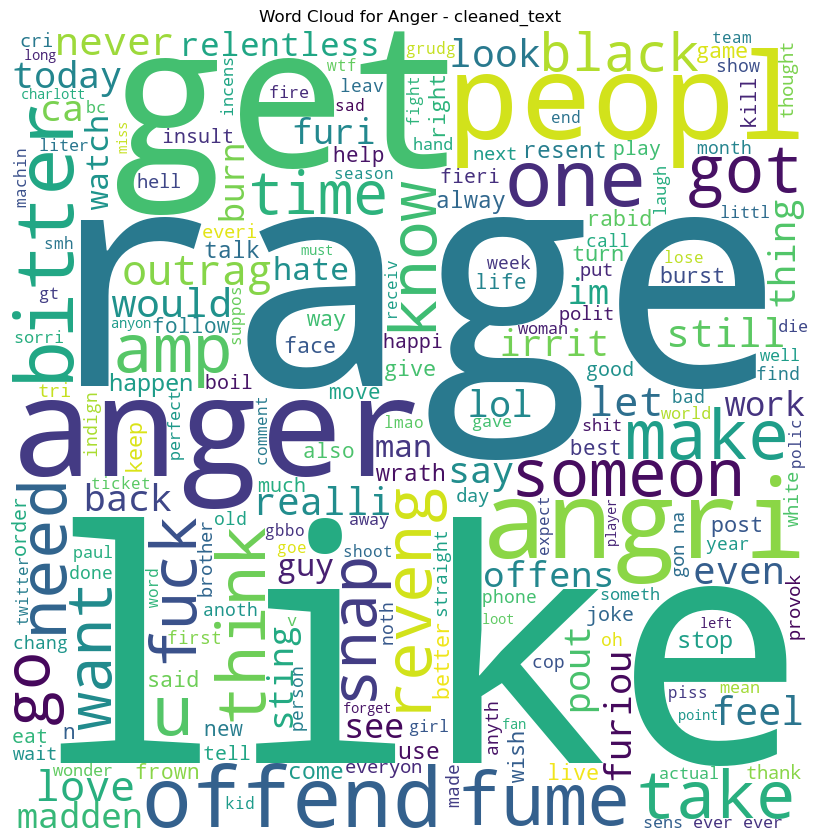

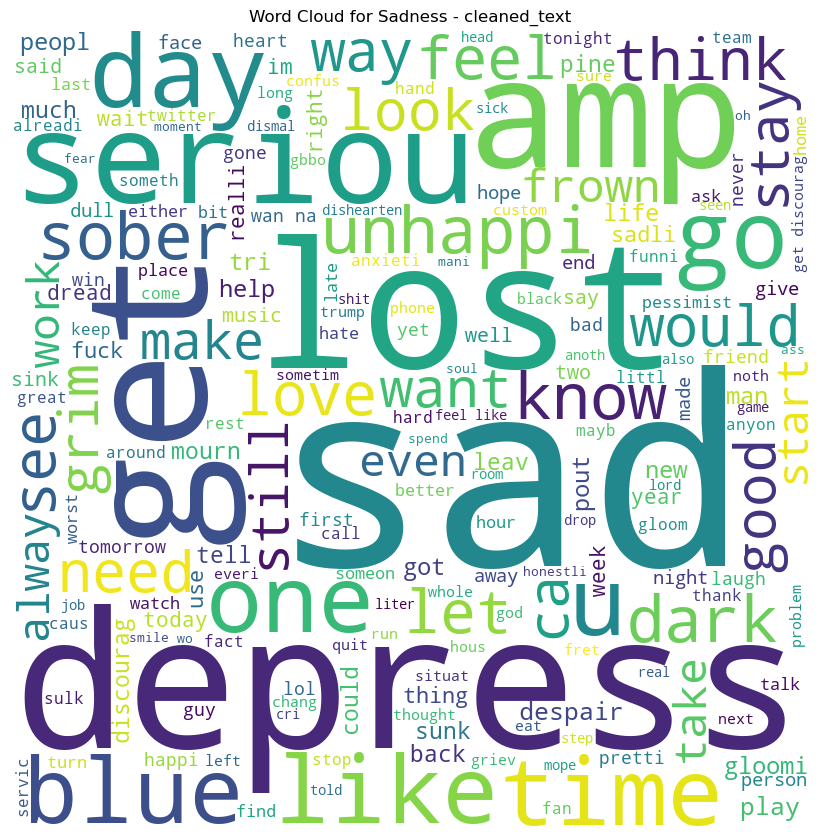

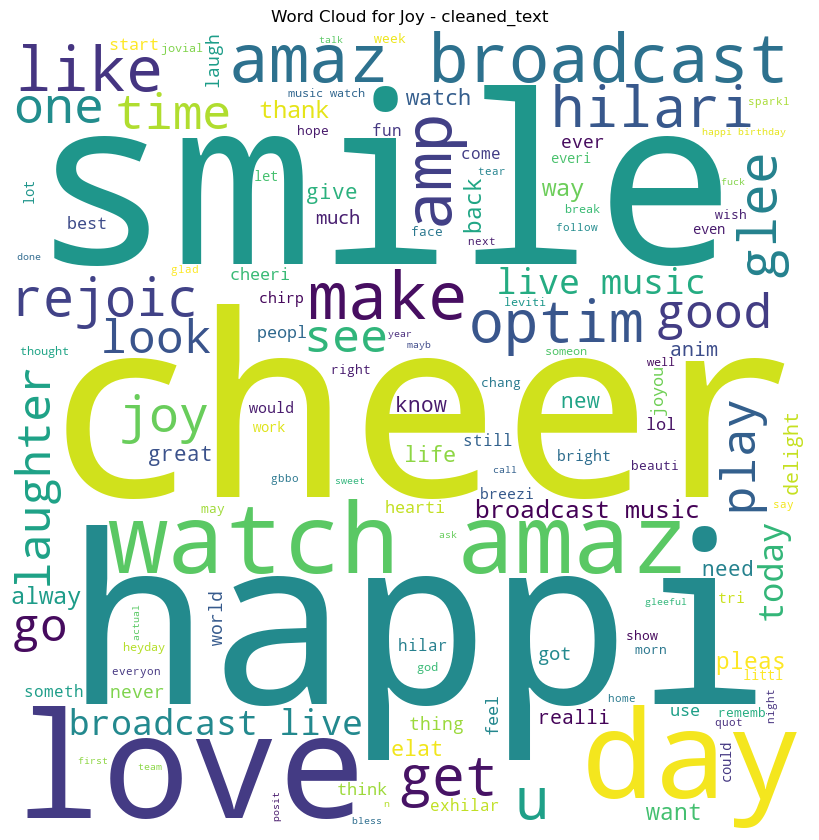

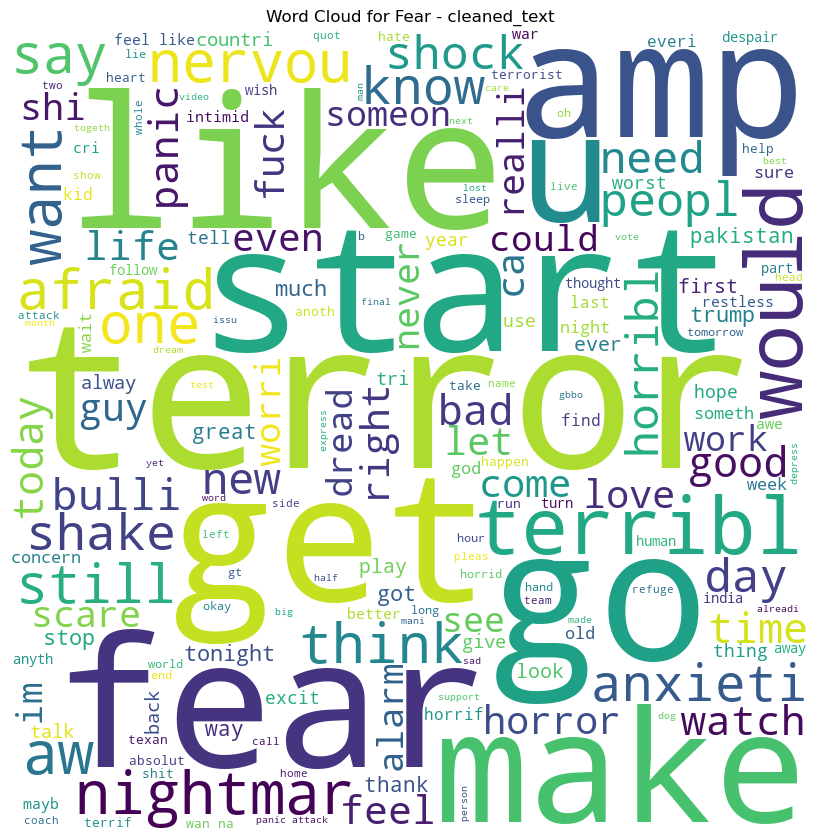

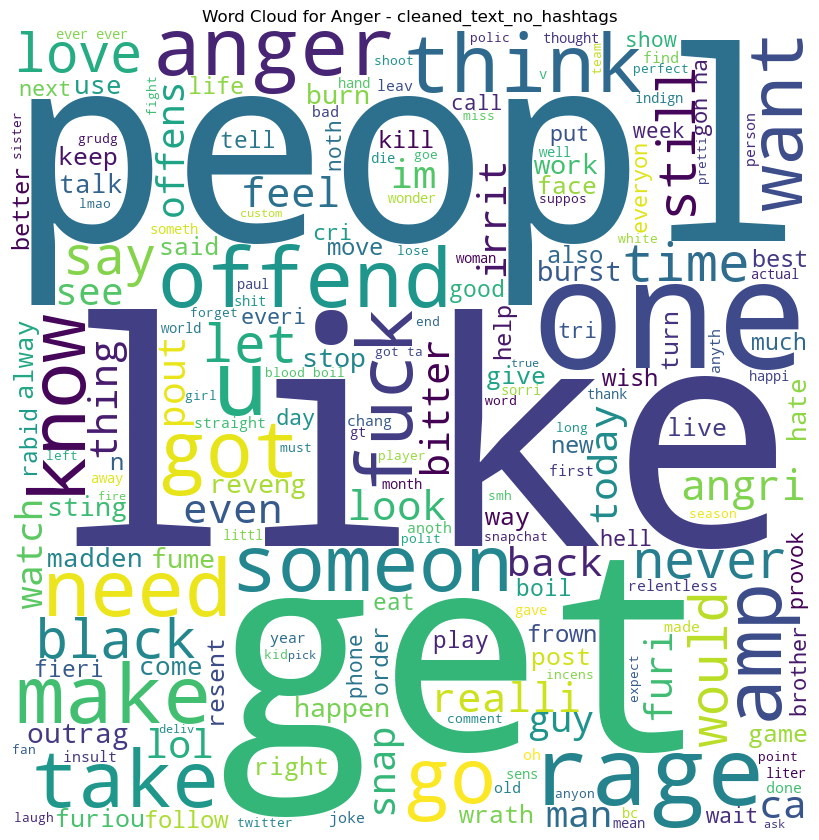

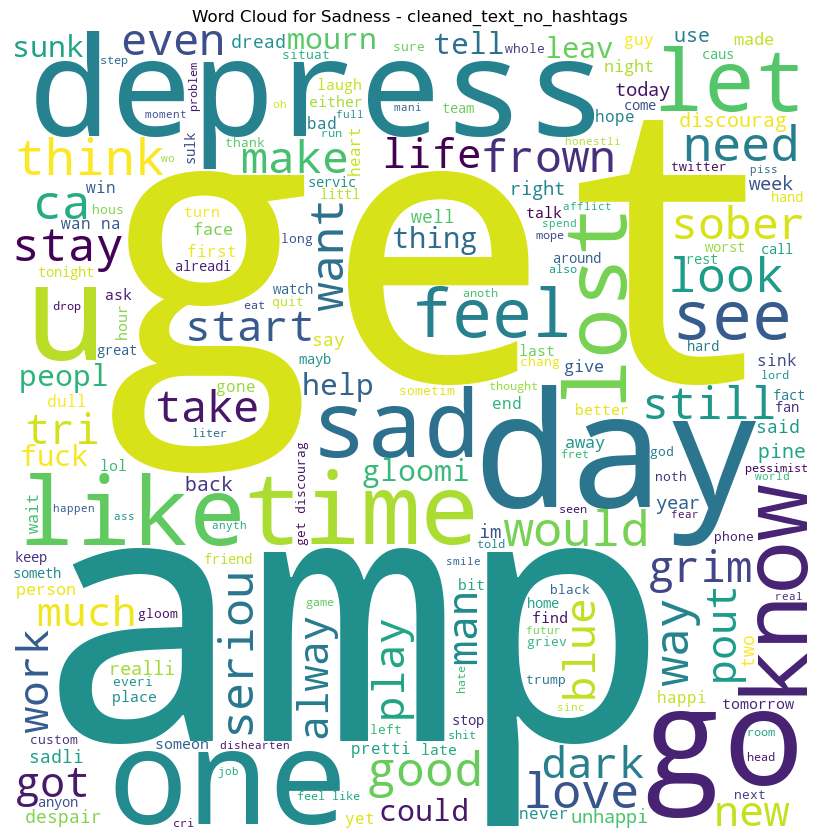

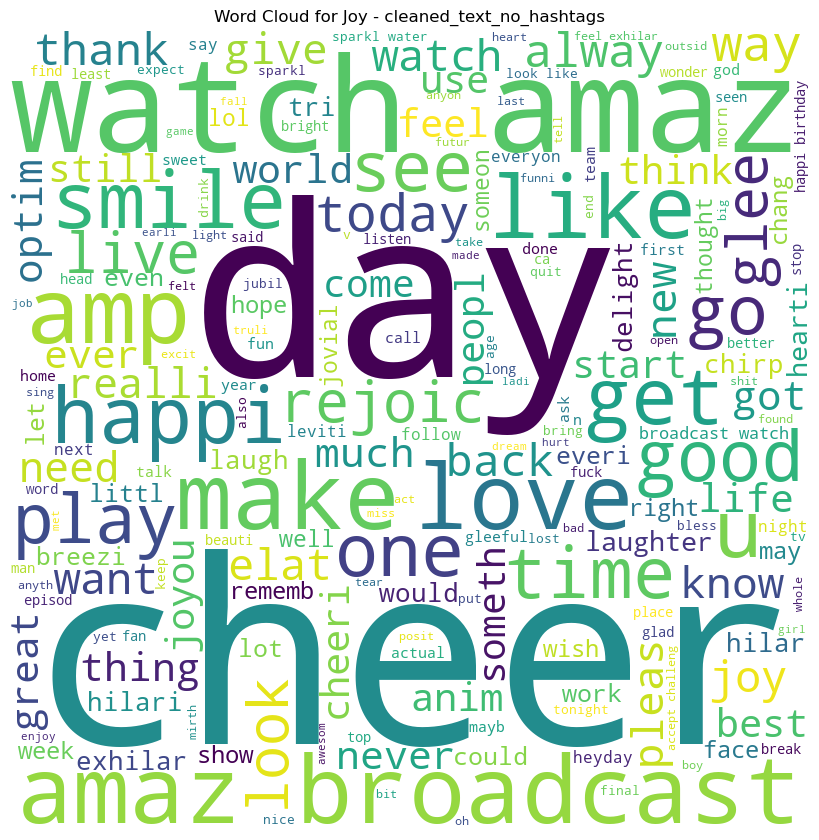

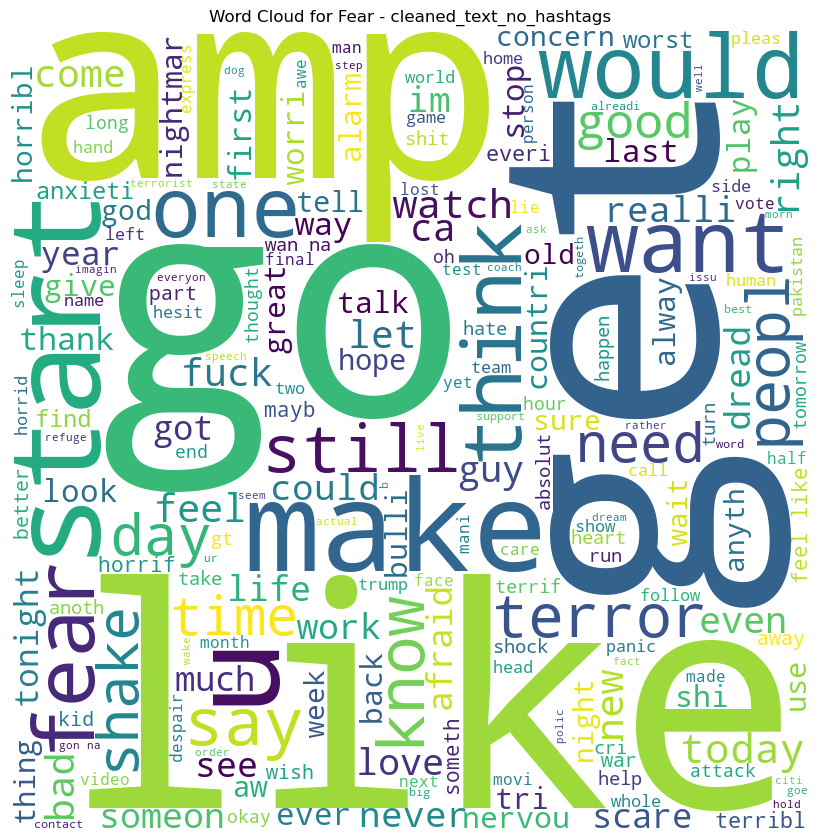

In [9]:
def generate_wordclouds_for_emotions(df, column_name):
    # Define emotions
    emotions = ['anger', 'sadness', 'joy', 'fear']
    
    # Generate and plot word clouds for each emotion
    for emotion in emotions:
        # Filter dataframe for the specific emotion
        df_emotion = df[df['label'] == emotion]
        
        # Generate the word cloud for the specific emotion
        wordcloud = WordCloud(width=800, height=800, 
                              background_color='white', 
                              stopwords=stop_words, 
                              min_font_size=10).generate(' '.join(df_emotion[column_name]))
        
        # Plot the word cloud
        plt.figure(figsize=(8, 8), facecolor=None) 
        plt.imshow(wordcloud) 
        plt.axis("off") 
        plt.tight_layout(pad=0) 
        plt.title(f"Word Cloud for {emotion.capitalize()} - {column_name}")
        plt.show()

# Generate word clouds for each emotion for the 'cleaned_text' column which includes hashtags
generate_wordclouds_for_emotions(train_df, 'cleaned_text')

# Generate word clouds for each emotion for the 'cleaned_text_no_hashtags' column which excludes hashtags
generate_wordclouds_for_emotions(train_df, 'cleaned_text_no_hashtags')


In [10]:
# Define a function to find most common words by emotion
def most_common_words_by_emotion(df, emotion, text_column, n_most_common=10):
    # Filter the DataFrame by the specified emotion
    emotion_df = df[df['label'] == emotion]
    
    # Initialize CountVectorizer with the specified thresholds
    vectorizer = CountVectorizer(max_df=0.5, min_df=2)
    
    # Fit and transform the text_column
    X = vectorizer.fit_transform(emotion_df[text_column])
    
    # Sum words occurrence
    sum_words = X.sum(axis=0)
    
    # Get the feature names (which are the words)
    words = vectorizer.get_feature_names_out()
    
    # Map word indices to words
    words_freq = [(word, sum_words[0, idx]) for word, idx in zip(words, range(len(words)))]
    
    # Sort words by frequency
    sorted_words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    return sorted_words_freq[:n_most_common]

# Emotion classes
emotion_classes = ['anger', 'sadness', 'joy', 'fear']

# List to keep track of common words for each emotion
emotion_common_words = {}

# Loop through each emotion and get the most common words with and without hashtags
for emotion in emotion_classes:
    emotion_common_words[emotion] = {
        'with_hashtags': most_common_words_by_emotion(train_df, emotion, 'cleaned_text'),
        'without_hashtags': most_common_words_by_emotion(train_df, emotion, 'cleaned_text_no_hashtags')
    }

# Now, emotion_common_words contains the most common words for each emotion, distinguished between with and without hashtags.
# Let's print them out to see
for emotion, word_types in emotion_common_words.items():
    print(f"Most common words for {emotion.upper()}:")
    print("With Hashtags:")
    for word, freq in word_types['with_hashtags']:
        print(f"{word}: {freq}")
    print("\nWithout Hashtags:")
    for word, freq in word_types['without_hashtags']:
        print(f"{word}: {freq}")
    print("\n" + "-"*50 + "\n")

Most common words for ANGER:
With Hashtags:
like: 70
rage: 64
get: 55
anger: 53
peopl: 51
angri: 47
offend: 47
bitter: 44
one: 43
fume: 35

Without Hashtags:
like: 70
get: 55
peopl: 50
one: 43
rage: 36
got: 35
anger: 31
make: 31
offend: 31
amp: 30

--------------------------------------------------

Most common words for SADNESS:
With Hashtags:
sad: 77
depress: 70
get: 63
lost: 61
amp: 46
like: 42
seriou: 42
time: 41
day: 40
go: 36

Without Hashtags:
get: 63
amp: 46
like: 41
day: 40
time: 39
depress: 37
go: 36
one: 35
feel: 33
sad: 33

--------------------------------------------------

Most common words for JOY:
With Hashtags:
watch: 86
cheer: 81
happi: 78
smile: 69
amaz: 63
love: 61
day: 60
live: 57
music: 55
broadcast: 54

Without Hashtags:
watch: 86
cheer: 71
day: 62
amaz: 61
broadcast: 54
like: 54
make: 53
amp: 52
love: 51
happi: 50

--------------------------------------------------

Most common words for FEAR:
With Hashtags:
terror: 93
like: 87
go: 74
get: 72
fear: 67
start: 66


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3613 samples in 0.002s...
[t-SNE] Computed neighbors for 3613 samples in 0.854s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3613
[t-SNE] Computed conditional probabilities for sample 2000 / 3613
[t-SNE] Computed conditional probabilities for sample 3000 / 3613
[t-SNE] Computed conditional probabilities for sample 3613 / 3613
[t-SNE] Mean sigma: 0.319723
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.998322
[t-SNE] KL divergence after 300 iterations: 3.250704


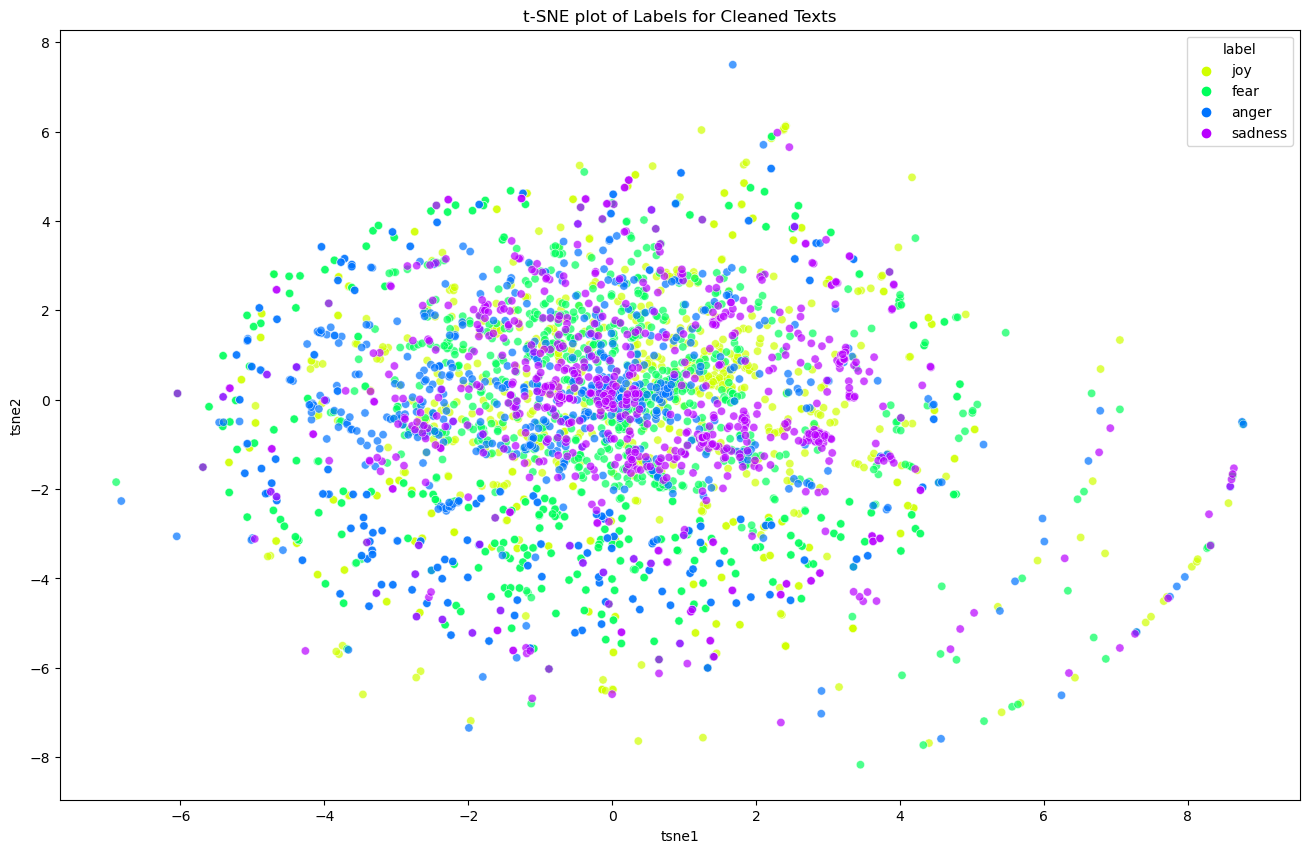

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3613 samples in 0.002s...
[t-SNE] Computed neighbors for 3613 samples in 0.492s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3613
[t-SNE] Computed conditional probabilities for sample 2000 / 3613
[t-SNE] Computed conditional probabilities for sample 3000 / 3613
[t-SNE] Computed conditional probabilities for sample 3613 / 3613
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 105.492180
[t-SNE] KL divergence after 300 iterations: 3.719548


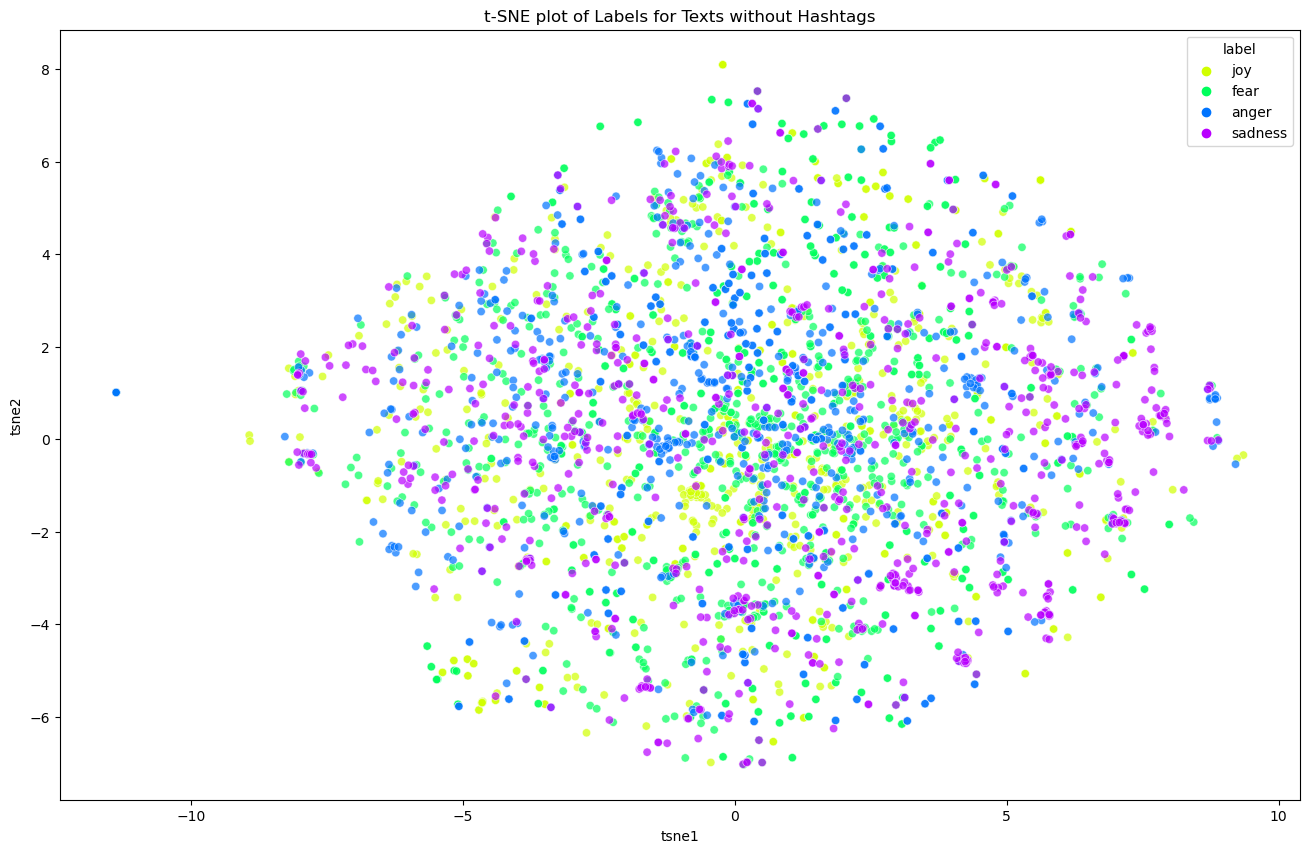

In [11]:
# Function to perform t-SNE and plot
def plot_tsne(data, labels, title):
    # Check if data is in a sparse matrix format and convert it to a dense array
    if isinstance(data, csr_matrix):
        data = data.todense()

    # If the data is a NumPy matrix, convert it to a NumPy array as t-SNE does not support 'np.matrix'
    if isinstance(data, np.matrix):
        data = np.asarray(data)
    
    # Perform t-SNE embedding, this can take a while depending on your dataset size and your computer's computational power
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(data)

    # Create a DataFrame that holds the t-SNE results and the corresponding labels
    df_tsne = pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])
    df_tsne['label'] = labels.reset_index(drop=True)  # Reset index if labels Series comes from a DataFrame

    # Plotting the t-SNE results
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="tsne1", y="tsne2",
        hue="label",
        palette=sns.color_palette("hsv", len(df_tsne['label'].unique())),
        data=df_tsne,
        legend="full",
        alpha=0.7
    )
    plt.title(title)
    plt.show()

# Replace 'X_train_cleaned' and 'X_train_no_hashtags' with your actual data variable names.
# Replace 'train_df['label']' with the actual labels from your DataFrame.
# These variables should be defined with the actual data before calling this function.
plot_tsne(X_train_cleaned, train_df['label'], 't-SNE plot of Labels for Cleaned Texts')
plot_tsne(X_train_no_hashtags, train_df['label'], 't-SNE plot of Labels for Texts without Hashtags')

# Models

### Multinomial Naive Bayes

In [12]:
# Split the cleaned dataset into training and testing sets
X_train_cleaned, X_test_cleaned, y_train, y_test = train_test_split(
    train_df['cleaned_text'], train_df['label'], test_size=0.2, random_state=42)

# Split the no hashtags dataset into training and testing sets
X_train_no_hashtags, X_test_no_hashtags, _, _ = train_test_split(
    train_df['cleaned_text_no_hashtags'], train_df['label'], test_size=0.2, random_state=42)

# Function to create, fit, and evaluate a model
def create_fit_evaluate_model(X_train, X_test, y_train, y_test, description):
    pipeline = make_pipeline(
        TfidfVectorizer(),
        MultinomialNB()
    )

    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)

    # Predict the labels for the test data
    y_pred = pipeline.predict(X_test)

    # Evaluate the predictions
    print(f"Results for {description}:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("---------------------------------------------------\n")

# Evaluate model on cleaned text data
create_fit_evaluate_model(X_train_cleaned, X_test_cleaned, y_train, y_test, 'Cleaned Texts')

# Evaluate model on no hashtags text data
create_fit_evaluate_model(X_train_no_hashtags, X_test_no_hashtags, y_train, y_test, 'Texts without Hashtags')

Results for Cleaned Texts:
Accuracy: 0.7676348547717843

Classification Report:
               precision    recall  f1-score   support

       anger       0.85      0.75      0.79       154
        fear       0.65      0.95      0.77       223
         joy       0.89      0.75      0.81       185
     sadness       0.85      0.57      0.68       161

    accuracy                           0.77       723
   macro avg       0.81      0.75      0.76       723
weighted avg       0.80      0.77      0.77       723

---------------------------------------------------

Results for Texts without Hashtags:
Accuracy: 0.661134163208852

Classification Report:
               precision    recall  f1-score   support

       anger       0.78      0.67      0.72       154
        fear       0.54      0.87      0.67       223
         joy       0.81      0.65      0.72       185
     sadness       0.71      0.37      0.48       161

    accuracy                           0.66       723
   macro avg    

### SVM (Linear)

In [13]:
# Split the dataset into training and testing sets for cleaned data
X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(
    train_df['cleaned_text'], train_df['label'], test_size=0.2, random_state=42)

# Split the dataset into training and testing sets for text without hashtags
X_train_no_hashtags, X_test_no_hashtags, y_train_no_hashtags, y_test_no_hashtags = train_test_split(
    train_df['cleaned_text_no_hashtags'], train_df['label'], test_size=0.2, random_state=42)

# Function to create, fit, and evaluate an SVM model
def create_fit_evaluate_svm_model(X_train, X_test, y_train, y_test, description):
    pipeline = make_pipeline(
        TfidfVectorizer(),
        SVC(kernel='linear')
    )

    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)

    # Predict the labels for the test data
    y_pred = pipeline.predict(X_test)

    # Evaluate the predictions
    print(f"Results for {description}:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("---------------------------------------------------\n")

# Evaluate SVM model on cleaned text data
create_fit_evaluate_svm_model(X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned, 'Cleaned Texts')

# Evaluate SVM model on text without hashtags
create_fit_evaluate_svm_model(X_train_no_hashtags, X_test_no_hashtags, y_train_no_hashtags, y_test_no_hashtags, 'Texts without Hashtags')

Results for Cleaned Texts:
Accuracy: 0.8423236514522822

Classification Report:
               precision    recall  f1-score   support

       anger       0.83      0.86      0.85       154
        fear       0.81      0.88      0.85       223
         joy       0.92      0.89      0.91       185
     sadness       0.80      0.71      0.75       161

    accuracy                           0.84       723
   macro avg       0.84      0.84      0.84       723
weighted avg       0.84      0.84      0.84       723

---------------------------------------------------

Results for Texts without Hashtags:
Accuracy: 0.7219917012448133

Classification Report:
               precision    recall  f1-score   support

       anger       0.73      0.73      0.73       154
        fear       0.68      0.79      0.73       223
         joy       0.84      0.81      0.82       185
     sadness       0.65      0.52      0.58       161

    accuracy                           0.72       723
   macro avg   

### SVM (Not Linear)

In [14]:
# Split the dataset into training and testing sets for cleaned data
X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(
    train_df['cleaned_text'], train_df['label'], test_size=0.2, random_state=42)

# Split the dataset into training and testing sets for text without hashtags
X_train_no_hashtags, X_test_no_hashtags, y_train_no_hashtags, y_test_no_hashtags = train_test_split(
    train_df['cleaned_text_no_hashtags'], train_df['label'], test_size=0.2, random_state=42)

# Function to create, fit, and evaluate an SVM model
def create_fit_evaluate_svm_model(X_train, X_test, y_train, y_test, description):
    pipeline = make_pipeline(
        TfidfVectorizer(),
        SVC()
    )

    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)

    # Predict the labels for the test data
    y_pred = pipeline.predict(X_test)

    # Evaluate the predictions
    print(f"Results for {description}:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("---------------------------------------------------\n")

# Evaluate SVM model on cleaned text data
create_fit_evaluate_svm_model(X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned, 'Cleaned Texts')

# Evaluate SVM model on text without hashtags
create_fit_evaluate_svm_model(X_train_no_hashtags, X_test_no_hashtags, y_train_no_hashtags, y_test_no_hashtags, 'Texts without Hashtags')

Results for Cleaned Texts:
Accuracy: 0.8409405255878285

Classification Report:
               precision    recall  f1-score   support

       anger       0.91      0.81      0.85       154
        fear       0.75      0.95      0.84       223
         joy       0.95      0.84      0.89       185
     sadness       0.84      0.73      0.78       161

    accuracy                           0.84       723
   macro avg       0.86      0.83      0.84       723
weighted avg       0.85      0.84      0.84       723

---------------------------------------------------

Results for Texts without Hashtags:
Accuracy: 0.7344398340248963

Classification Report:
               precision    recall  f1-score   support

       anger       0.81      0.72      0.76       154
        fear       0.65      0.88      0.75       223
         joy       0.86      0.78      0.82       185
     sadness       0.69      0.49      0.57       161

    accuracy                           0.73       723
   macro avg   

### SVM with GridSearch

In [15]:
# Split the dataset into training and testing sets for both feature sets
X_train_cleaned, X_test_cleaned, y_train, y_test = train_test_split(
    train_df['cleaned_text'], train_df['label'], test_size=0.2, random_state=42)

X_train_no_hashtags, X_test_no_hashtags, _, _ = train_test_split(
    train_df['cleaned_text_no_hashtags'], train_df['label'], test_size=0.2, random_state=42)

# Define a function to perform hyperparameter tuning
def hyperparameter_tuning(X_train, X_test, y_train, y_test, description):
    # Create a pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('svm', SVC())
    ])

    # Define the parameter grid
    parameter_grid = {
        'tfidf__max_df': [0.5, 0.75, 1.0],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'svm__C': [0.1, 1, 10],
        'svm__kernel': ['linear', 'rbf']
    }

    # Create a GridSearchCV object
    grid_search = GridSearchCV(pipeline, parameter_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)

    # Print out the best parameters
    print(f"Best parameters for {description}:")
    print(grid_search.best_params_)

    # Evaluate on the test set
    y_pred = grid_search.predict(X_test)
    print(f"Results for {description}:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("---------------------------------------------------\n")

    # Return the fitted grid search object for further inspection if necessary
    return grid_search

# Perform hyperparameter tuning on cleaned data
grid_search_cleaned = hyperparameter_tuning(X_train_cleaned, X_test_cleaned, y_train, y_test, 'Cleaned Texts')

# Perform hyperparameter tuning on data without hashtags
grid_search_no_hashtags = hyperparameter_tuning(X_train_no_hashtags, X_test_no_hashtags, y_train, y_test, 'Texts without Hashtags')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Cleaned Texts:
{'svm__C': 10, 'svm__kernel': 'linear', 'tfidf__max_df': 0.5, 'tfidf__ngram_range': (1, 2)}
Results for Cleaned Texts:
Accuracy: 0.8658367911479945

Classification Report:
               precision    recall  f1-score   support

       anger       0.86      0.85      0.86       154
        fear       0.85      0.91      0.88       223
         joy       0.92      0.92      0.92       185
     sadness       0.82      0.76      0.79       161

    accuracy                           0.87       723
   macro avg       0.86      0.86      0.86       723
weighted avg       0.87      0.87      0.87       723

---------------------------------------------------

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Texts without Hashtags:
{'svm__C': 10, 'svm__kernel': 'linear', 'tfidf__max_df': 0.5, 'tfidf__ngram_range': (1, 2)}
Results for Texts without Hashtags:
Accuracy

### XGBoost

In [16]:
# Convert the string labels into integers
label_encoder = LabelEncoder()
train_df['numeric_label'] = label_encoder.fit_transform(train_df['label'])

# Split the dataset into training and testing sets for both versions of the text
X_train_cleaned, X_test_cleaned, y_train, y_test = train_test_split(
    train_df['cleaned_text'], train_df['numeric_label'], test_size=0.2, random_state=42)

X_train_no_hashtags, X_test_no_hashtags, _, _ = train_test_split(
    train_df['cleaned_text_no_hashtags'], train_df['numeric_label'], test_size=0.2, random_state=42)

# Define a function for hyperparameter tuning with XGBoost
def hyperparameter_tuning_xgboost(X_train, X_test, y_train, y_test, description):
    # Define the pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
    ])

    # Define the parameter grid
    parameters = {
        'tfidf__max_df': (0.75, 0.85, 0.95),
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'xgb__max_depth': [6, 10, 15],
        'xgb__n_estimators': [50, 100, 200],
        'xgb__learning_rate': [0.01, 0.1, 0.2]
    }

    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipeline, parameters, cv=3, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)

    # Best parameters
    print(f"Best parameters for {description}:")
    print(grid_search.best_params_)

    # Best model
    best_model = grid_search.best_estimator_

    # Predict the labels for the test data
    y_pred = best_model.predict(X_test)

    # Evaluate the predictions
    print(f"Evaluation for {description}:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    return best_model

# Perform hyperparameter tuning on cleaned data
print("Tuning for cleaned text:")
best_model_cleaned = hyperparameter_tuning_xgboost(X_train_cleaned, X_test_cleaned, y_train, y_test, 'Cleaned Texts')

# Perform hyperparameter tuning on data without hashtags
print("\nTuning for text without hashtags:")
best_model_no_hashtags = hyperparameter_tuning_xgboost(X_train_no_hashtags, X_test_no_hashtags, y_train, y_test, 'Text Without Hashtags')

Tuning for cleaned text:
Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best parameters for Cleaned Texts:
{'tfidf__max_df': 0.75, 'tfidf__ngram_range': (1, 1), 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 200}
Evaluation for Cleaned Texts:
Accuracy: 0.8243430152143845

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.77      0.83       154
           1       0.71      0.90      0.79       223
           2       0.96      0.86      0.91       185
           3       0.85      0.73      0.78       161

    accuracy                           0.82       723
   macro avg       0.85      0.82      0.83       723
weighted avg       0.84      0.82      0.83       723


Tuning for text without hashtags:
Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best parameters for Text Without Hashtags:
{'tfidf__max_df': 0.75, 'tfidf__ngram_range': (1, 1), 'xgb__learning_rate': 0.2, 'xgb__ma

### Random Forest

In [17]:
pipeline_rf = make_pipeline(
    TfidfVectorizer(),
    RandomForestClassifier(random_state=42)
)

# Train and evaluate for cleaned text
pipeline_rf.fit(X_train_cleaned, y_train)
y_pred_cleaned = pipeline_rf.predict(X_test_cleaned)
print("Accuracy for cleaned text:", accuracy_score(y_test, y_pred_cleaned))
print("Classification Report for cleaned text:\n", classification_report(y_test, y_pred_cleaned))

# Train and evaluate for text without hashtags
pipeline_rf.fit(X_train_no_hashtags, y_train)
y_pred_no_hashtag = pipeline_rf.predict(X_test_no_hashtags)
print("Accuracy for text without hashtags:", accuracy_score(y_test, y_pred_no_hashtag))
print("Classification Report for text without hashtags:\n", classification_report(y_test, y_pred_no_hashtag))

Accuracy for cleaned text: 0.8271092669432918
Classification Report for cleaned text:
               precision    recall  f1-score   support

           0       0.87      0.77      0.82       154
           1       0.74      0.91      0.82       223
           2       0.93      0.89      0.91       185
           3       0.84      0.70      0.76       161

    accuracy                           0.83       723
   macro avg       0.84      0.82      0.82       723
weighted avg       0.84      0.83      0.83       723

Accuracy for text without hashtags: 0.7745504840940526
Classification Report for text without hashtags:
               precision    recall  f1-score   support

           0       0.80      0.76      0.78       154
           1       0.73      0.84      0.78       223
           2       0.80      0.90      0.85       185
           3       0.79      0.55      0.65       161

    accuracy                           0.77       723
   macro avg       0.78      0.76      0.77    

### LSTM

In [18]:
# Tokenize the text
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['cleaned_text'])

# Convert the text to sequences
X_train_sequences = tokenizer.texts_to_sequences(train_df['cleaned_text'])
X_val_sequences = tokenizer.texts_to_sequences(val_df['cleaned_text'])
X_test_sequences = tokenizer.texts_to_sequences(test_df['cleaned_text'])

# Pad the sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=200)
X_val_padded = pad_sequences(X_val_sequences, maxlen=200)
X_test_padded = pad_sequences(X_test_sequences, maxlen=200)

# Convert labels to categorical if they are not numerical
y_train_categorical = pd.get_dummies(train_df['label']).values
y_val_categorical = pd.get_dummies(val_df['label']).values
y_test_categorical = pd.get_dummies(test_df['label']).values

In [19]:
# Model architecture
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=64, input_length=200))
model.add(Dropout(0.2))
model.add(LSTM(100, dropout=0.2))  # Removed recurrent_dropout for compatibility
model.add(Dense(4, activation='softmax'))  # Assuming 4 emotion categories

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Metal device set to: Apple M2


2023-11-14 21:54:49.351213: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-14 21:54:49.352538: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [20]:
# Training
epochs = 5
batch_size = 64

history = model.fit(X_train_padded, y_train_categorical, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_data=(X_val_padded, y_val_categorical),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)],
                    verbose=1)

Epoch 1/5


2023-11-14 21:54:49.746326: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-11-14 21:54:50.391099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-14 21:54:50.550001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-14 21:54:50.956172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


57/57 [==============================] - ETA: 0s - loss: 1.3279 - accuracy: 0.3839

2023-11-14 21:54:57.633754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-14 21:54:57.674970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


57/57 [==============================] - 9s 120ms/step - loss: 1.3279 - accuracy: 0.3839 - val_loss: 1.3839 - val_accuracy: 0.3545
Epoch 2/5
57/57 [==============================] - 6s 101ms/step - loss: 0.9647 - accuracy: 0.7321 - val_loss: 1.5661 - val_accuracy: 0.4294
Epoch 3/5
57/57 [==============================] - 6s 110ms/step - loss: 0.6906 - accuracy: 0.8168 - val_loss: 1.6451 - val_accuracy: 0.5187
Epoch 4/5
57/57 [==============================] - 6s 109ms/step - loss: 0.3959 - accuracy: 0.9136 - val_loss: 1.7669 - val_accuracy: 0.5418


In [21]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test_categorical, verbose=1)
print(f"Test Loss (Hashtags): {test_loss}")
print(f"Test Accuracy (Hashtags): {test_accuracy}")

99/99 [==============================] - 4s 34ms/step - loss: 1.6424 - accuracy: 0.5328
Test Loss (Hashtags): 1.6423929929733276
Test Accuracy (Hashtags): 0.5327816605567932


In [22]:
# Tokenize the 'cleaned_text_no_hashtags'
tokenizer_no_hashtags = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer_no_hashtags.fit_on_texts(train_df['cleaned_text_no_hashtags'])

# Convert to sequences and pad
X_train_no_hashtags_padded = pad_sequences(tokenizer_no_hashtags.texts_to_sequences(train_df['cleaned_text_no_hashtags']), maxlen=200)
X_val_no_hashtags_padded = pad_sequences(tokenizer_no_hashtags.texts_to_sequences(val_df['cleaned_text_no_hashtags']), maxlen=200)
X_test_no_hashtags_padded = pad_sequences(tokenizer_no_hashtags.texts_to_sequences(test_df['cleaned_text_no_hashtags']), maxlen=200)

In [23]:
# Model architecture for cleaned_text_no_hashtags
model_no_hashtags = Sequential()
model_no_hashtags.add(Embedding(input_dim=5000, output_dim=64, input_length=200))
model_no_hashtags.add(Dropout(0.2))
model_no_hashtags.add(LSTM(100, dropout=0.2))
model_no_hashtags.add(Dense(4, activation='softmax'))  # Assuming 4 emotion categories

model_no_hashtags.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training for cleaned_text_no_hashtags
epochs = 5
batch_size = 64

history_no_hashtags = model_no_hashtags.fit(X_train_no_hashtags_padded, y_train_categorical, 
                                            epochs=epochs, 
                                            batch_size=batch_size,
                                            validation_data=(X_val_no_hashtags_padded, y_val_categorical),
                                            callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)],
                                            verbose=1)

Epoch 1/5


2023-11-14 21:55:20.900805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-14 21:55:21.023373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-14 21:55:21.376923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


57/57 [==============================] - ETA: 0s - loss: 1.3607 - accuracy: 0.3230

2023-11-14 21:55:27.748736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-14 21:55:27.791466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


57/57 [==============================] - 8s 115ms/step - loss: 1.3607 - accuracy: 0.3230 - val_loss: 1.3506 - val_accuracy: 0.3026
Epoch 2/5
57/57 [==============================] - 6s 109ms/step - loss: 1.0239 - accuracy: 0.6333 - val_loss: 1.8246 - val_accuracy: 0.4035
Epoch 3/5
57/57 [==============================] - 6s 113ms/step - loss: 0.4623 - accuracy: 0.8727 - val_loss: 2.7923 - val_accuracy: 0.4265
Epoch 4/5
57/57 [==============================] - 6s 113ms/step - loss: 0.2296 - accuracy: 0.9314 - val_loss: 3.2313 - val_accuracy: 0.3573


In [24]:
# Evaluate the model on the test set for cleaned_text_no_hashtags
test_loss_no_hashtags, test_accuracy_no_hashtags = model_no_hashtags.evaluate(X_test_no_hashtags_padded, y_test_categorical, verbose=1)
print(f"Test Loss (No Hashtags): {test_loss_no_hashtags}")
print(f"Test Accuracy (No Hashtags): {test_accuracy_no_hashtags}")

99/99 [==============================] - 3s 32ms/step - loss: 3.1016 - accuracy: 0.3218
Test Loss (No Hashtags): 3.101586103439331
Test Accuracy (No Hashtags): 0.3217695653438568


The model with the highest accuracy was SVM with GridSearch. Between hashtags and no hashtag tweets, tweets with hashtags had a higher accuracy. Therefore, we are Twitter should include hashtags in tweets when we conduct sentiment analysis.